## Target Guided Encoding

- Capture valuable information while encoding 
- Ordering according to the target variable 
- Imputing using the probability of target variable 
- Using weight of evidence 

### Monotonicity and its implications in Target Guided Encoding

A monotonic relationship either:

- Increases the value of one variable with the increase in the value of the other variable 

- Decreases the value of one variable with the increase in the value of the other variable 

The target guided encoding methods assume a monotonic relationship.

### Pros

- Capture information 
- Do not expand feature space

### Cons

- Might cause overfitting


### Probability Ratio Encoding 

- Numbers taken from the target variables 

- Calculate the probability of target being 1 for each label

- Calculate the probability of target being 0 for each label

- Divide the two 



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [25]:
from google.colab import drive
drive.mount('/content/gdrive')
data = pd.read_csv("gdrive/My Drive/Colab Notebooks/FeatureEngineering/train.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [27]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [28]:
data = data.drop(['Name'], axis=1)

In [29]:
# Get variables with more than n categories 
n = 10
cats = []
for col in data.columns:
    if data[col].dtypes =='O': 
        if len(data[col].unique())>n: 
            print('{} categories : {} '.format(col, len(data[col].unique())))
            cats.append(col)

Ticket categories : 681 
Cabin categories : 148 


In [30]:
data = data[cats+['Survived']]

In [31]:
for col in cats:
  print("{} unique categories : {}".format(col,len(data[col].unique())))

Ticket unique categories : 681
Cabin unique categories : 148


In [32]:
for col in cats:
  print("{} Missing : {}".format(col,data[col].isnull().sum()))

Ticket Missing : 0
Cabin Missing : 687


In [33]:
data.head()

,Ticket,Cabin,Survived
0,A/5 21171,NaN,0
1,PC 17599,C85,1
2,STON/O2. 3101282,NaN,1
3,113803,C123,1
4,373450,NaN,0


In [34]:
for col in cats:
  data[col].fillna('MissingData', inplace=True)

In [35]:
data.head()

,Ticket,Cabin,Survived
0,A/5 21171,MissingData,0
1,PC 17599,C85,1
2,STON/O2. 3101282,MissingData,1
3,113803,C123,1
4,373450,MissingData,0


In [36]:
data['Cabin'] = data['Cabin'].astype(str).str[0]
data.head()

,Ticket,Cabin,Survived
0,A/5 21171,M,0
1,PC 17599,C,1
2,STON/O2. 3101282,M,1
3,113803,C,1
4,373450,M,0


In [37]:
for col in cats:
  print("{} unique categories : {}".format(col,len(data[col].unique())))

Ticket unique categories : 681
Cabin unique categories : 9


In [38]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[cats], data['Survived'],
                                                    test_size=0.2)
X_train.shape, X_test.shape

((712, 2), (179, 2))

In [39]:
def tg_probability_ratio(Xtrain, Xtest, y_train, columns):
  X_train, X_test = Xtrain.copy(), Xtest.copy()
  _temp = pd.concat([X_train, y_train], axis=1)
  for col in columns:
    p = pd.DataFrame(_temp.groupby([col])[y_train.name].mean())
    p[y_train.name + "!"] =  1-p[y_train.name]
    p['ratio'] = p[y_train.name]/p[y_train.name + "!"]
    mapper = p['ratio'].to_dict()
    X_train[col] = X_train[col].map(mapper)
    X_test[col] = X_test[col].map(mapper)
  return X_train, X_test, mapper

In [40]:
X_train_encoded, X_test_encoded, mapper = tg_probability_ratio(X_train, X_test, y_train, ['Cabin'])

In [41]:
mapper

{'A': 1.75,
 'B': 3.5555555555555562,
 'C': 1.3684210526315785,
 'D': 6.666666666666665,
 'E': 2.571428571428571,
 'F': 3.5000000000000004,
 'G': 1.0,
 'M': 0.4476439790575916,
 'T': 0.0}

In [42]:
X_train.head()

,Ticket,Cabin
98,231919,M
157,SOTON/OQ 392090,M
828,367228,M
536,113050,B
220,SOTON/OQ 392089,M


In [43]:
X_train_encoded.head()

,Ticket,Cabin
98,231919,0.447644
157,SOTON/OQ 392090,0.447644
828,367228,0.447644
536,113050,3.555556
220,SOTON/OQ 392089,0.447644


In [45]:
sns.set()
# Explore Monotony
def monotony_plot(X_train, X_train_encoded, y_train, columns):
  for col in columns:
    fig = plt.figure()
    _temp = pd.concat([X_train, y_train], axis=1)
    fig = _temp.groupby([col])[y_train.name].mean().plot()
    fig.set_title('Unprocessed')
    fig = plt.figure()
    _temp = pd.concat([X_train_encoded, y_train], axis=1)
    fig = _temp.groupby([col])[y_train.name].mean().plot()
    fig.set_title('Processed')


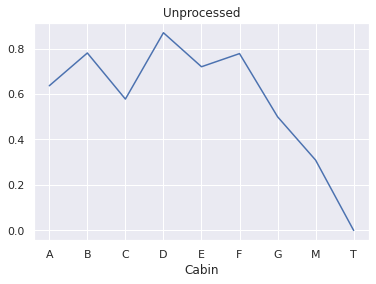

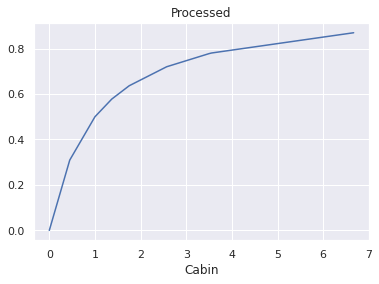

In [46]:
monotony_plot(X_train, X_train_encoded, y_train, ['Cabin'])